In [139]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import xgboost as xgb
# from xgboost import XGBRegressor
from fitter import Fitter
# from scipy import signal
from pandas.plotting import autocorrelation_plot
# # from sklearn import preprocessing
# from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from clusteval import clusteval
from df2onehot import df2onehot
# from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_friedman1
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.impute import IterativeImputer
from sklearn import linear_model

sns.set_style('darkgrid')
# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt
# from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.metrics import accuracy_score,confusion_matrix
# from pandas.plotting import lag_plot
# from pmdarima.arima import auto_arima
%matplotlib inline
# import shap

In [140]:
os.chdir('G:/My Drive/Robyn_Stuff/Robyn/')

In [141]:
smd_pivot = pd.read_csv('eo_context_4.csv')
# ts_pivot = pd.read_csv('ts_pivot.csv')
# ct = pd.read_csv('ct_spend.csv') # need information on revenue or impressions
# dm_pivot = pd.read_csv('dm_pivot_2.csv')

This summary of different stats for the original model can be compared to the .describe()
of the imputed dataset to see how it changed (or didn't change).

In [142]:
df = smd_pivot
df.describe()

,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S,revenue
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,4401.456395,464.768547,1967.342326,2927.935349,2584.759186,13787.436512,1556.526047,95278.449302
std,4615.438261,646.838552,1869.274951,2882.351080,2023.343047,6899.716980,1548.531411,27984.974843
min,0.000000,0.000000,0.000000,0.000000,158.130000,1625.880000,34.810000,32134.510000
25%,0.000000,116.280000,488.947500,312.447500,1110.750000,9331.922500,346.525000,76007.087500
50%,3758.330000,298.135000,1244.580000,2055.200000,1789.010000,12251.535000,1170.170000,93945.470000
75%,5527.582500,470.962500,3107.095000,5015.460000,4060.507500,17062.922500,2192.205000,109930.700000
max,24634.650000,4209.840000,8287.340000,12808.270000,8513.440000,49020.900000,6163.160000,174302.250000


In [183]:
def missing_values(df):
    names = [var for var in df.columns]
    missing_count = df[names].isnull().sum()
    var_count = np.array(df[names].isnull().sum() * 100/ len(df)).round(2)
    missing = pd.DataFrame(index=names)
    missing["Count Missing"] = missing_count
    missing["Percent Missing"] = var_count
    print(missing)


def unique(df):
    percent_unique = np.array(100 * df.nunique()/len(df.index)).round(2)
    count_unique = df.nunique()
    names = [var for var in df.columns]
    unique_df = pd.DataFrame(index=names)
    unique_df["Count Unique"] = count_unique
    unique_df["Percent Unique"] = percent_unique
    print(unique_df)


def corr_plot(df):
    corr_temp = df.drop(['DATE'], axis=1)
    corr_names = corr_temp.columns.tolist()
    temp_df = df[corr_names]
    corr = temp_df.corr(method="pearson").round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(8, 8))
    cmap = sns.diverging_palette(250, 1, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def distributions(df):
    for var in temp_df:
        dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']
        dist_test = temp_df[var].dropna()
        dist_test = dist_test.values
        f = Fitter(dist_test, distributions=dist_list, timeout=60)
        f.fit()
        print(var)
        # print(f.summary(plot=False))
        print(f.get_best(method='sumsquare_error'))


def summary(df):
    print(missing_values(df))
    print(unique(df))
    corr_plot(df)

This summary gives us information on missing values, the number of unique values, and correlation before imputation.
In some cases, it suggests that columns of entirely missing data might be dropped right away. Once again, it is valuable
to compare to the imputed result.

                 Count Missing  Percent Missing
DATE                         0              0.0
revenue                      0              0.0
display_S                    0              0.0
b_branded_S                  0              0.0
b_category_S                 0              0.0
p_auto_S                     0              0.0
p_brand_S                    0              0.0
p_category_S                 0              0.0
p_competitive_S              0              0.0
None
                 Count Unique  Percent Unique
DATE                      172          100.00
revenue                   172          100.00
display_S                 127           73.84
b_branded_S               171           99.42
b_category_S              151           87.79
p_auto_S                  144           83.72
p_brand_S                 172          100.00
p_category_S              172          100.00
p_competitive_S           172          100.00
None


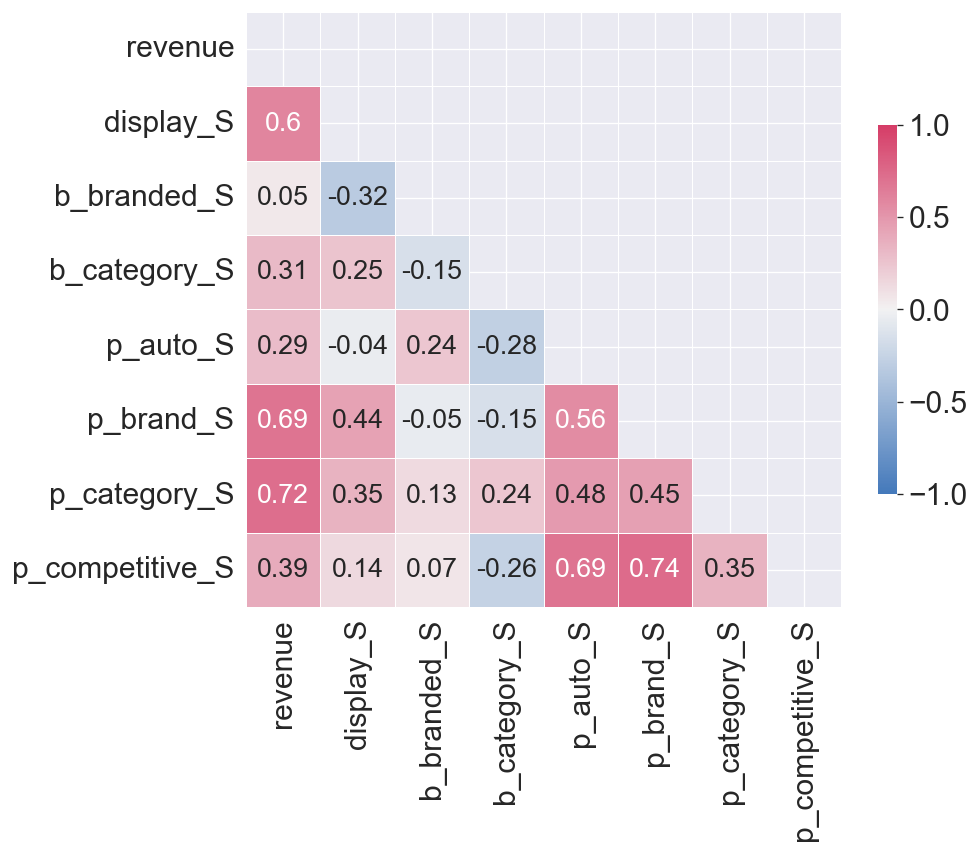

In [184]:
summary(df)

Helps drop variables when necessary and creates a few variables that will be used later.

                 Count Missing  Percent Missing
DATE                         0              0.0
revenue                      0              0.0
display_S                    0              0.0
b_branded_S                  0              0.0
b_category_S                 0              0.0
p_auto_S                     0              0.0
p_brand_S                    0              0.0
p_category_S                 0              0.0
p_competitive_S              0              0.0
None
                 Count Unique  Percent Unique
DATE                      172          100.00
revenue                   172          100.00
display_S                 127           73.84
b_branded_S               171           99.42
b_category_S              151           87.79
p_auto_S                  144           83.72
p_brand_S                 172          100.00
p_category_S              172          100.00
p_competitive_S           172          100.00
None


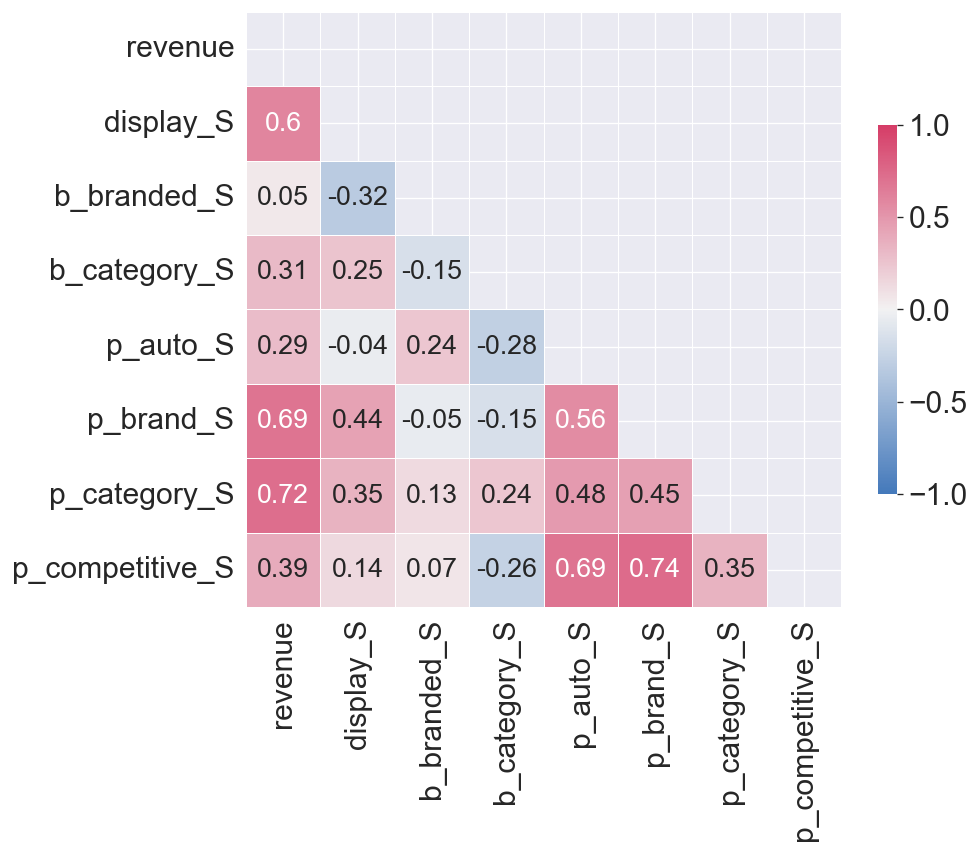

In [185]:
df_zero = df.fillna(0)

df_zero['display'] = df_zero['display_S']
df_zero['product'] = df_zero['p_auto_S'] + df_zero['p_brand_S'] + df_zero['p_category_S'] + df_zero['p_competitive_S']
df_zero['brand'] = df_zero['b_branded_S'] + df_zero['b_category_S']

summary(df)

                 Count Missing  Percent Missing
DATE                         0              0.0
revenue                      0              0.0
display_S                    0              0.0
b_branded_S                  0              0.0
b_category_S                 0              0.0
p_auto_S                     0              0.0
p_brand_S                    0              0.0
p_category_S                 0              0.0
p_competitive_S              0              0.0
None
                 Count Unique  Percent Unique
DATE                      172          100.00
revenue                   172          100.00
display_S                 127           73.84
b_branded_S               171           99.42
b_category_S              151           87.79
p_auto_S                  144           83.72
p_brand_S                 172          100.00
p_category_S              172          100.00
p_competitive_S           172          100.00
None


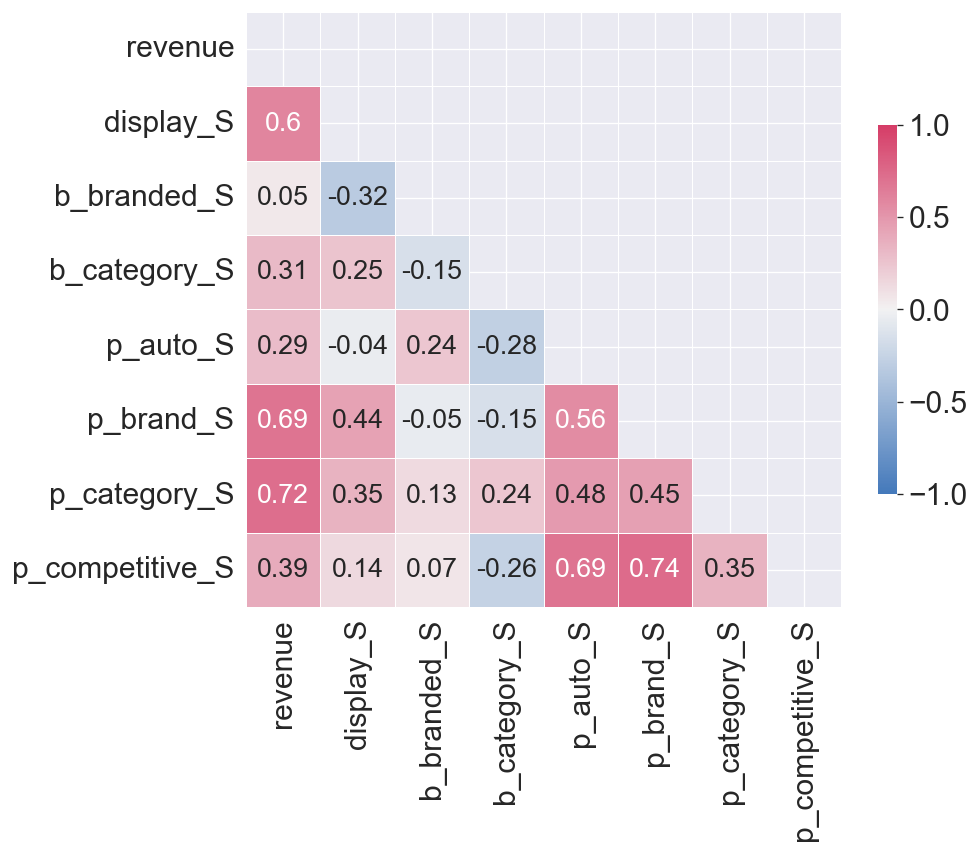

In [186]:
# df = df.drop([], axis=1)
df = df[['DATE', 'revenue', 'display_S', 'b_branded_S', 'b_category_S',
         'p_auto_S', 'p_brand_S', 'p_category_S', 'p_competitive_S']]
temp_week = df['DATE']
corr_temp = df.drop(['DATE'], axis=1)
corr_names = corr_temp.columns.tolist()
summary(df)

Will be repeating this test to see how the distributions change after imputation

In [187]:
temp_df = df.drop(['DATE'], axis=1)
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in temp_df:
    dist_test = temp_df[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 95.90it/s]


revenue
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma       3.173357e-09  2459.543294 -4235.704424     inf      0.051528  \
norm        3.299820e-09  2459.487770 -4234.130480     inf      0.067117   
cauchy      3.505300e-09  2500.133441 -4223.740289     inf      0.093343   
uniform     5.521606e-09  2376.952581 -4145.584747     inf      0.216256   
expon       6.998148e-09  2439.783101 -4104.824760     inf      0.285691   

            ks_pvalue  
gamma    7.311224e-01  
norm     4.029083e-01  
cauchy   9.362488e-02  
uniform  1.532913e-07  
expon    6.422544e-13  
{'gamma': {'a': 14.025798455365049, 'loc': -9471.167739310808, 'scale': 7468.353147437869}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 50.05it/s]


display_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma       4.869512e-07  2480.349258 -3369.964093     inf      0.422286  \
expon       1.017071e-06  2241.631304 -3248.430484     inf      0.273233   
cauchy      1.200314e-06  2280.370209 -3219.937517     inf      0.188143   
norm        1.209630e-06  2409.275994 -3218.607722     inf      0.169429   
uniform     1.345786e-06  2026.381853 -3200.261623     inf      0.537389   

            ks_pvalue  
gamma    2.501035e-28  
expon    7.742801e-12  
cauchy   8.359782e-06  
norm     8.724868e-05  
uniform  5.568285e-47  
{'gamma': {'a': 0.35223756065033573, 'loc': -5.858413931014343e-25, 'scale': 4827.510787952294}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 60.83it/s]


b_branded_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma           0.000005  2569.347787 -2954.701295     inf      0.115467  \
expon           0.000006  2138.100700 -2952.820238     inf      0.115527   
cauchy          0.000010  2104.821613 -2848.535747     inf      0.177561   
norm            0.000019  2483.347564 -2745.934006     inf      0.249929   
uniform         0.000029  1673.035984 -2670.180656     inf      0.698279   

            ks_pvalue  
gamma    1.871916e-02  
expon    1.862819e-02  
cauchy   3.247993e-05  
norm     5.939009e-10  
uniform  1.662128e-84  
{'gamma': {'a': 1.218950009543284, 'loc': -8.405007114047741, 'scale': 275.525812310683}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 50.56it/s]


b_category_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma           0.000002  2077.000537 -3135.789172     inf      0.227715  \
expon           0.000002  1942.133216 -3113.053348     inf      0.127907   
cauchy          0.000003  2037.990349 -3051.262168     inf      0.227624   
norm            0.000003  1994.946495 -3039.000843     inf      0.154999   
uniform         0.000004  1808.496866 -3016.011064     inf      0.389687   

            ks_pvalue  
gamma    2.544938e-08  
expon    6.514553e-03  
cauchy   2.582415e-08  
norm     4.486689e-04  
uniform  4.931489e-24  
{'gamma': {'a': 0.7059746776983162, 'loc': -8.460832968235085e-24, 'scale': 1650.006516213396}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.25it/s]


p_auto_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma           0.000002  2294.413287 -3163.252527     inf      0.302799  \
expon           0.000002  2037.861133 -3102.266005     inf      0.196949   
cauchy          0.000003  2120.107512 -3065.526565     inf      0.244494   
norm            0.000003  2092.276971 -3063.023780     inf      0.154154   
uniform         0.000003  1895.569267 -3051.379477     inf      0.427267   

            ks_pvalue  
gamma    1.730186e-14  
expon    2.541196e-06  
cauchy   1.540933e-09  
norm     4.915637e-04  
uniform  5.078230e-29  
{'gamma': {'a': 0.638459250546058, 'loc': -8.286846887712048e-24, 'scale': 2010.6396385944317}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 89.07it/s]


p_brand_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma           0.000001  1910.279043 -3203.688276     inf      0.092432  \
cauchy          0.000001  2039.247675 -3205.775777     inf      0.194835   
expon           0.000002  1907.169225 -3177.308767     inf      0.139867   
norm            0.000002  1927.957947 -3128.721271     inf      0.189437   
uniform         0.000002  1810.130509 -3106.229559     inf      0.379388   

            ks_pvalue  
gamma    9.930836e-02  
cauchy   3.399488e-06  
expon    2.131347e-03  
norm     7.042410e-06  
uniform  9.255755e-23  
{'gamma': {'a': 1.4651705218707538, 'loc': 143.55669398749234, 'scale': 1666.155893241567}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 56.90it/s]


p_category_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
gamma       1.750294e-08  2494.999513 -3942.000842     inf      0.049103  \
norm        2.257669e-08  2631.694049 -3903.365862     inf      0.096113   
cauchy      2.507703e-08  2379.200936 -3885.300016     inf      0.103651   
expon       6.086355e-08  2274.918823 -3732.790658     inf      0.257960   
uniform     7.496293e-08  2157.254488 -3696.952871     inf      0.480199   

            ks_pvalue  
gamma    7.824154e-01  
norm     7.797708e-02  
cauchy   4.614388e-02  
expon    1.394245e-10  
uniform  5.344610e-37  
{'gamma': {'a': 9.246082084047512, 'loc': -5420.8330059700165, 'scale': 2053.7731731728272}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 54.21it/s]

p_competitive_S
         sumsquare_error          aic          bic  kl_div  ks_statistic   
expon           0.000006  1872.245043 -2953.722417     inf      0.167013  \
gamma           0.000006  1872.977930 -2947.228128     inf      0.154304   
cauchy          0.000007  1983.123617 -2907.453193     inf      0.267129   
norm            0.000008  1887.281294 -2899.017506     inf      0.185817   
uniform         0.000009  1748.136165 -2880.765279     inf      0.433437   

            ks_pvalue  
expon    1.159636e-04  
gamma    4.836335e-04  
cauchy   2.511171e-11  
norm     1.134343e-05  
uniform  6.831687e-30  
{'expon': {'loc': 34.81, 'scale': 1521.7160465116278}}


In [148]:
df.describe()

,revenue,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,95278.449302,4401.456395,464.768547,1967.342326,2927.935349,2584.759186,13787.436512,1556.526047
std,27984.974843,4615.438261,646.838552,1869.274951,2882.351080,2023.343047,6899.716980,1548.531411
min,32134.510000,0.000000,0.000000,0.000000,0.000000,158.130000,1625.880000,34.810000
25%,76007.087500,0.000000,116.280000,488.947500,312.447500,1110.750000,9331.922500,346.525000
50%,93945.470000,3758.330000,298.135000,1244.580000,2055.200000,1789.010000,12251.535000,1170.170000
75%,109930.700000,5527.582500,470.962500,3107.095000,5015.460000,4060.507500,17062.922500,2192.205000
max,174302.250000,24634.650000,4209.840000,8287.340000,12808.270000,8513.440000,49020.900000,6163.160000


The KNNImputer uses a method similar to regression and nearby non-missing values to fill in missing values.
The number of neighboring values can be adjusted to find better fits for the missing values.

In [188]:
knn_df_names = tuple(corr_names)
knn_temp = df[corr_names]
df_knn = knn_temp.filter(knn_df_names, axis=1).copy()

In [189]:
# # KNN Imputation
knn_df_names = tuple(corr_names)
knn_temp = df[corr_names]
df_knn = knn_temp.filter(knn_df_names, axis=1).copy()
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

In [190]:
# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed), columns=df_knn.columns)
KNN_imputation = pd.concat([df_knn_imputed, temp_week], axis=1)

Multiple Imputation by Chained Equations (MICE) uses iterations of Bayesian Ridge Linear models
and takes the averages of their results to determine the imputed values. Compared to most other methods,
it performs better with extremely sparse data.

In [152]:
mice_names = tuple(corr_names)
mice_temp = df[corr_names]
df_mice = mice_temp.filter(mice_names, axis=1).copy()
mice_estimator = IterativeImputer(estimator=linear_model.BayesianRidge(), sample_posterior=True, max_iter=40,
                                n_nearest_features=10, imputation_order='random')
df_mice_imputed = pd.DataFrame(mice_estimator.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed = df_mice_imputed.apply(lambda x: x.abs(), axis=1)
imputed_mice = pd.concat([df_mice_imputed, temp_week], axis=1)

In [153]:
imputed_mice.to_csv('smd_mice_2.csv', encoding='utf-8', index=False)
KNN_imputation.to_csv('smd_KNN_2.csv', encoding='utf-8', index=False)

### Post Hoc Tests

Of particular interest here is noticing the differences between the means and the standard deviations

In [154]:
KNN_imputation.describe()

,revenue,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,95278.449302,4401.456395,464.768547,1967.342326,2927.935349,2584.759186,13787.436512,1556.526047
std,27984.974843,4615.438261,646.838552,1869.274951,2882.351080,2023.343047,6899.716980,1548.531411
min,32134.510000,0.000000,0.000000,0.000000,0.000000,158.130000,1625.880000,34.810000
25%,76007.087500,0.000000,116.280000,488.947500,312.447500,1110.750000,9331.922500,346.525000
50%,93945.470000,3758.330000,298.135000,1244.580000,2055.200000,1789.010000,12251.535000,1170.170000
75%,109930.700000,5527.582500,470.962500,3107.095000,5015.460000,4060.507500,17062.922500,2192.205000
max,174302.250000,24634.650000,4209.840000,8287.340000,12808.270000,8513.440000,49020.900000,6163.160000


In [155]:
df.describe()

,revenue,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,95278.449302,4401.456395,464.768547,1967.342326,2927.935349,2584.759186,13787.436512,1556.526047
std,27984.974843,4615.438261,646.838552,1869.274951,2882.351080,2023.343047,6899.716980,1548.531411
min,32134.510000,0.000000,0.000000,0.000000,0.000000,158.130000,1625.880000,34.810000
25%,76007.087500,0.000000,116.280000,488.947500,312.447500,1110.750000,9331.922500,346.525000
50%,93945.470000,3758.330000,298.135000,1244.580000,2055.200000,1789.010000,12251.535000,1170.170000
75%,109930.700000,5527.582500,470.962500,3107.095000,5015.460000,4060.507500,17062.922500,2192.205000
max,174302.250000,24634.650000,4209.840000,8287.340000,12808.270000,8513.440000,49020.900000,6163.160000


In [156]:
imputed_mice.describe()

,revenue,display_S,b_branded_S,b_category_S,p_auto_S,p_brand_S,p_category_S,p_competitive_S
count,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000,172.000000
mean,95278.449302,4401.456395,464.768547,1967.342326,2927.935349,2584.759186,13787.436512,1556.526047
std,27984.974843,4615.438261,646.838552,1869.274951,2882.351080,2023.343047,6899.716980,1548.531411
min,32134.510000,0.000000,0.000000,0.000000,0.000000,158.130000,1625.880000,34.810000
25%,76007.087500,0.000000,116.280000,488.947500,312.447500,1110.750000,9331.922500,346.525000
50%,93945.470000,3758.330000,298.135000,1244.580000,2055.200000,1789.010000,12251.535000,1170.170000
75%,109930.700000,5527.582500,470.962500,3107.095000,5015.460000,4060.507500,17062.922500,2192.205000
max,174302.250000,24634.650000,4209.840000,8287.340000,12808.270000,8513.440000,49020.900000,6163.160000


The Augmented Dickey-Fuller function tests if a time series needs differencing,
which returns True, or if the time series is stationary. It also implies that
if the test returns True, it is not a random walk and the imputation is somewhat
decent, at the minimum.

In [161]:
mice_no_date = imputed_mice[['revenue']]
adfuller(mice_no_date)

(-2.9615308238760867,
 0.038646476591570604,
 3,
 168,
 {'1%': -3.4698858990744115,
  '5%': -2.8789026251889647,
  '10%': -2.5760266680839004},
 3504.06830365714)

In [163]:
knn_no_date = KNN_imputation[['revenue']]
adfuller(knn_no_date)

(-2.961530823876086,
 0.03864647659157073,
 3,
 168,
 {'1%': -3.4698858990744115,
  '5%': -2.8789026251889647,
  '10%': -2.5760266680839004},
 3504.06830365714)

Autocorrelation is another test for time series that tests if the current date's value is correlated
with previous observations. If the blue line is above the dotted line, this suggests the time series
is autocorrelated as well as the time series not being random.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

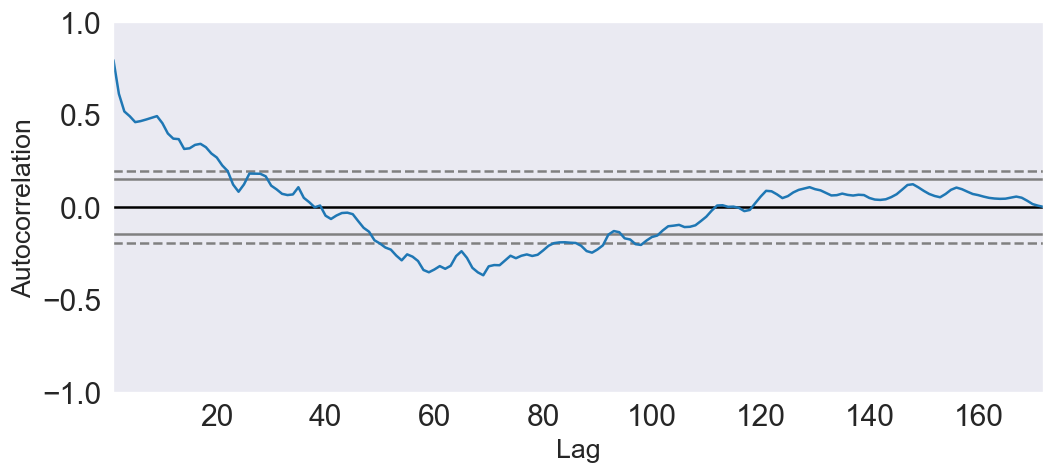

In [164]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(imputed_mice['revenue'].tolist())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

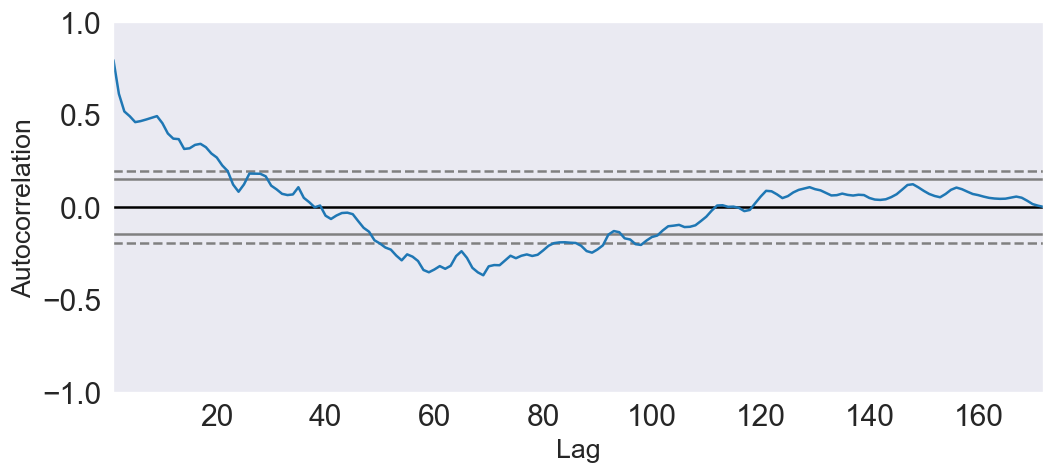

In [165]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(KNN_imputation['revenue'].tolist())

The following tests plot the distribution of the variables in the imputed dataset,
as well as give you the most likely distribution of its parameters. This can be useful
for testing if the distribution is known or comparing against a similar variable whose
distribution as known. It could also be used in creating synthetic data.

In [166]:
temp_df = df.drop(['DATE'], axis=1)
temp_mice = imputed_mice.drop(['DATE'], axis=1)
temp_KNN = KNN_imputation.drop(['DATE'], axis=1)

distributions(temp_df)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 91.48it/s]


revenue
{'gamma': {'a': 14.025798455365049, 'loc': -9471.167739310808, 'scale': 7468.353147437869}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 49.60it/s]


display_S
{'gamma': {'a': 0.35223756065033573, 'loc': -5.858413931014343e-25, 'scale': 4827.510787952294}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 55.41it/s]


b_branded_S
{'gamma': {'a': 1.218950009543284, 'loc': -8.405007114047741, 'scale': 275.525812310683}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 46.76it/s]


b_category_S
{'gamma': {'a': 0.7059746776983162, 'loc': -8.460832968235085e-24, 'scale': 1650.006516213396}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 45.48it/s]


p_auto_S
{'gamma': {'a': 0.638459250546058, 'loc': -8.286846887712048e-24, 'scale': 2010.6396385944317}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 88.60it/s]


p_brand_S
{'gamma': {'a': 1.4651705218707538, 'loc': 143.55669398749234, 'scale': 1666.155893241567}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


p_category_S
{'gamma': {'a': 9.246082084047512, 'loc': -5420.8330059700165, 'scale': 2053.7731731728272}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 52.96it/s]

p_competitive_S
{'expon': {'loc': 34.81, 'scale': 1521.7160465116278}}


In [167]:
distributions(temp_mice)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 88.53it/s]


revenue
{'gamma': {'a': 14.025798455365049, 'loc': -9471.167739310808, 'scale': 7468.353147437869}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


display_S
{'gamma': {'a': 0.35223756065033573, 'loc': -5.858413931014343e-25, 'scale': 4827.510787952294}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 57.60it/s]


b_branded_S
{'gamma': {'a': 1.218950009543284, 'loc': -8.405007114047741, 'scale': 275.525812310683}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 49.47it/s]


b_category_S
{'gamma': {'a': 0.7059746776983162, 'loc': -8.460832968235085e-24, 'scale': 1650.006516213396}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.91it/s]


p_auto_S
{'gamma': {'a': 0.638459250546058, 'loc': -8.286846887712048e-24, 'scale': 2010.6396385944317}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 90.63it/s]


p_brand_S
{'gamma': {'a': 1.4651705218707538, 'loc': 143.55669398749234, 'scale': 1666.155893241567}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 58.99it/s]


p_category_S
{'gamma': {'a': 9.246082084047512, 'loc': -5420.8330059700165, 'scale': 2053.7731731728272}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.33it/s]

p_competitive_S
{'expon': {'loc': 34.81, 'scale': 1521.7160465116278}}


In [168]:
distributions(temp_KNN)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 88.23it/s]


revenue
{'gamma': {'a': 14.025798455365049, 'loc': -9471.167739310808, 'scale': 7468.353147437869}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 49.58it/s]


display_S
{'gamma': {'a': 0.35223756065033573, 'loc': -5.858413931014343e-25, 'scale': 4827.510787952294}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 57.55it/s]


b_branded_S
{'gamma': {'a': 1.218950009543284, 'loc': -8.405007114047741, 'scale': 275.525812310683}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 46.10it/s]


b_category_S
{'gamma': {'a': 0.7059746776983162, 'loc': -8.460832968235085e-24, 'scale': 1650.006516213396}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 49.63it/s]


p_auto_S
{'gamma': {'a': 0.638459250546058, 'loc': -8.286846887712048e-24, 'scale': 2010.6396385944317}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 88.24it/s]


p_brand_S
{'gamma': {'a': 1.4651705218707538, 'loc': 143.55669398749234, 'scale': 1666.155893241567}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


p_category_S
{'gamma': {'a': 9.246082084047512, 'loc': -5420.8330059700165, 'scale': 2053.7731731728272}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.57it/s]

p_competitive_S
{'expon': {'loc': 34.81, 'scale': 1521.7160465116278}}


<Axes: xlabel='revenue', ylabel='Density'>

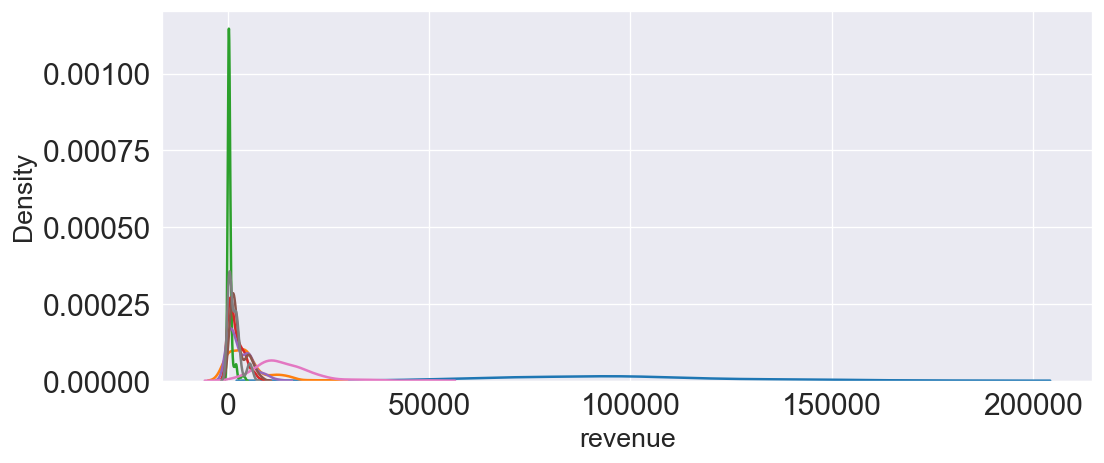

In [169]:
sns.kdeplot(data=KNN_imputation['revenue'])
sns.kdeplot(data=KNN_imputation['display_S'])
sns.kdeplot(data=KNN_imputation['b_branded_S'])
sns.kdeplot(data=KNN_imputation['b_category_S'])
sns.kdeplot(data=KNN_imputation['p_auto_S'])
sns.kdeplot(data=KNN_imputation['p_brand_S'])
sns.kdeplot(data=KNN_imputation['p_category_S'])
sns.kdeplot(data=KNN_imputation['p_competitive_S'])

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='display_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='display_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='display_S', data=df, legend=True)

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='b_branded_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='b_branded_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='b_branded_S', data=df, legend=True)

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='b_category_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='b_category_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='b_category_S', data=df, legend=True)

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='p_auto_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='p_auto_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='p_auto_S', data=df, legend=True)

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='p_brand_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='p_brand_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='p_brand_S', data=df, legend=True)

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='p_category_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='p_category_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='p_category_S', data=df, legend=True)

In [ ]:
figure, axes = plt.subplots(3, figsize=(10, 10))

sns.kdeplot(ax=axes[0], x='p_competitive_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1], x='p_competitive_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2], x='p_competitive_S', data=df, legend=True)

In [ ]:
summary(imputed_mice)

In [ ]:
summary(KNN_imputation)

In [ ]:
X, y = make_friedman1(n_samples=100, n_features=8)
# estimator = SVR(kernel="linear")
rfe = RFE(RandomForestRegressor(n_estimators=100, criterion='absolute_error'), importance_getter='auto')
fit = rfe.fit(X, y)
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

In [ ]:
names = df.columns.values[0:-1]
li = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        li.append(names[i])
print(li)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:00<00:00, 645.91it/s]
[clusteval] >INFO> Compute dendrogram threshold.
[clusteval] >INFO> Optimal number clusters detected: [3].
[clusteval] >INFO> Fin.


[0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 2 2 2 0 2 2 2 2 2 0 0
 0 0 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 1 2 2 2 2 2 1 1 2 1 2 2 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 2 2 2 2 1 2 2 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 2 2 2 0 0 2
 2 0 0 0 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


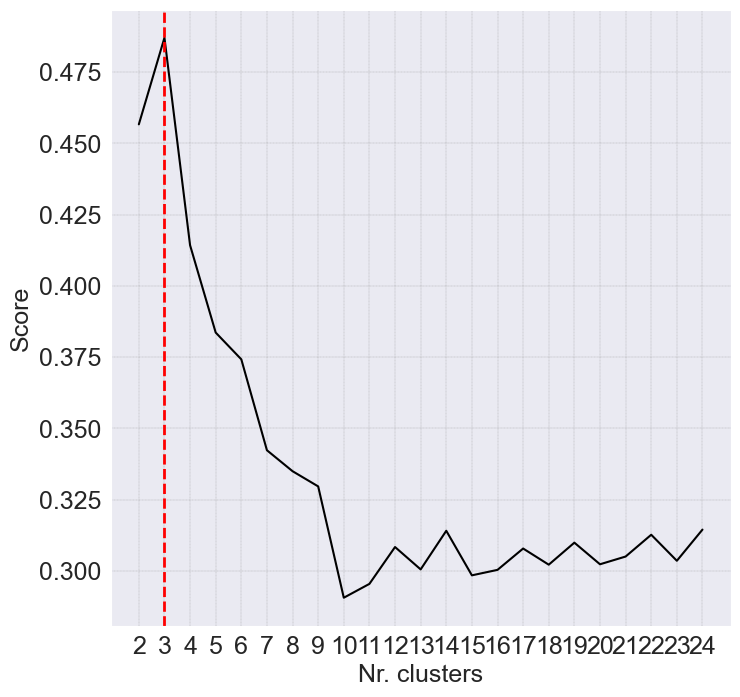

[clusteval] >INFO> Coordinates (x, y) are set based on the first two features.
[clusteval] >INFO> Estimated number of n_clusters: 3, average silhouette_score=0.539


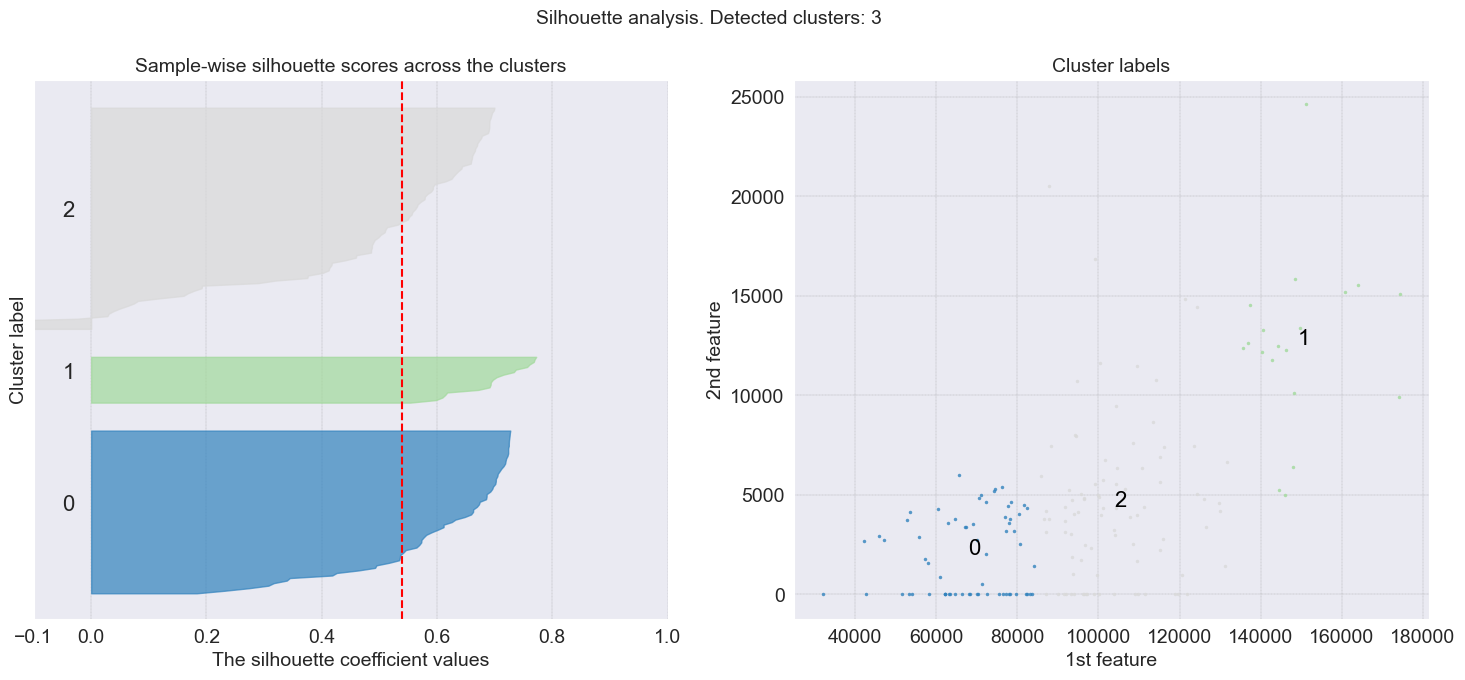

(<Figure size 1800x700 with 2 Axes>,
 <Axes: title={'center': 'Sample-wise silhouette scores across the clusters'}, xlabel='The silhouette coefficient values', ylabel='Cluster label'>,
 <Axes: title={'center': 'Cluster labels'}, xlabel='1st feature', ylabel='2nd feature'>)

In [173]:
# Initialize clusteval
# ce = clusteval()
df_no_date = df.drop('DATE', axis=1)
# Preprocessing
# cols_as_float = ['ProductRelated', 'Administrative']
# df[cols_as_float]=df[cols_as_float].astype(float)
ce = clusteval(cluster='agglomerative', evaluate='silhouette', min_clust=2, verbose='info')
results = ce.fit(df_no_date)

# The clustering label can be found in:
print(results['labx'])

# Make plots
ce.plot(figsize=(8, 8))
# ce.scatter(df_no_date, figsize=(8, 8))
ce.plot_silhouette(df_no_date, figsize=(8, 8))
# ce.dendrogram(max_d=8, figsize=(8, 8))
# print(y['labx'])